# Cesium D1 and D2 transitions

## Libraries

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
from scipy.signal import find_peaks, peak_widths
#from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
import plotly.graph_objects as go
from IPython.display import Image

plt.rcParams['text.usetex'] = True

## Functions

In [ ]:
def plots(file_name, folder_name, initial_index, final_index):
    for i in range(initial_index, final_index + 1):

        #defining file and path names
        name = file_name + str(i)
        file_path = folder_name + name + '.csv'

        #importing and separating the data
        data = pd.read_csv(file_path, skiprows=2, names=['time', 'volt_piezo', 'volt_photodiod'], dtype={'timestamp': float, 'volt_piezo': float, 'volt_photodiod': float})

        #remove all NaN data
        data_cleaned = data.dropna()

        #Plot t-V photodiod
        plt.scatter(data['time'].to_numpy(), data['volt_photodiod'].to_numpy(), s = 1)
        plt.xlabel('t [s]')
        plt.ylabel('V [V]')
        plt.title(name)
        plt.grid()
        plt.savefig(folder_name + name + '_t_V_photodiod')
        plt.close()

        #Plot t-V piezo
        plt.scatter(data['time'].to_numpy(), data['volt_piezo'].to_numpy(), s = 1)
        plt.xlabel('t [s]')
        plt.ylabel('V [V]')
        plt.title(name)
        plt.grid()
        plt.savefig(folder_name + name + '_t_V_piezo')
        plt.close()

        #Plot V-V
        plt.scatter(data['volt_piezo'].to_numpy(), data['volt_photodiod'].to_numpy(), s = 1)
        plt.xlabel('V [V]')
        plt.ylabel('V [V]')
        plt.title(name)
        plt.grid()
        plt.savefig(folder_name + name + '_V_V')
        plt.close()

def Retta(x, m, q):
    return m*x + q

def Lorentzian(x, A, x0, gamma):
    return A / (1 + ((x - x0) / gamma) ** 2)

def Gaussian(x, sigma, x0):
    return np.exp(-((x-x0)**2)/(2*sigma**2))/(np.sqrt(2.0*np.pi*sigma**2))

## Plots of raw data

In [34]:
plots('acope_', 'Data/Preliminari/', 29, 33)
plots('scope_', 'Data/Data_15_11/', 0, 14)

## Calibration

Per calibrare a dovere la scala necessitiamo di vedere tutti e 6 i picchi della transizione D2, dalla presa dati del 15/11/2024 risultano idonei solo scope_5 (cal_1) e scope_13 (cal_2). Verranno quindi effettuate due calibrazioni indipendenti e verranno successivamente comparate.

Per avere una calibrazione della scala di tempo su quella di differenza di potenziale del PZT viene effettuato un fit lineare sulla rampa che definisce lo alimenta.

In [3]:
#Data import
data_cal_1 = pd.read_csv('Data/Calibration/cal_1.csv', skiprows=2, names=['time', 'volt_piezo', 'volt_photodiod'], dtype={'timestamp': float, 'volt_piezo': float, 'volt_photodiod': float})

data_cal_1 = data_cal_1.dropna()

time_1 = data_cal_1['time'].to_numpy()
piezo_1 = data_cal_1['volt_piezo'].to_numpy()
diod_1 = data_cal_1['volt_photodiod'].to_numpy()

data_cal_2 = pd.read_csv('Data/Calibration/cal_2.csv', skiprows=2, names=['time', 'volt_piezo', 'volt_photodiod'], dtype={'timestamp': float, 'volt_piezo': float, 'volt_photodiod': float})

data_cal_2 = data_cal_2.dropna()

time_2 = data_cal_2['time'].to_numpy()
piezo_2 = data_cal_2['volt_piezo'].to_numpy()

Linear fit y = mx + q with:
	m =  80.5587577089833  pm  1.9632971870280543e-05 
	q =  -2.0660294100578365  pm  3.889112965647993e-08


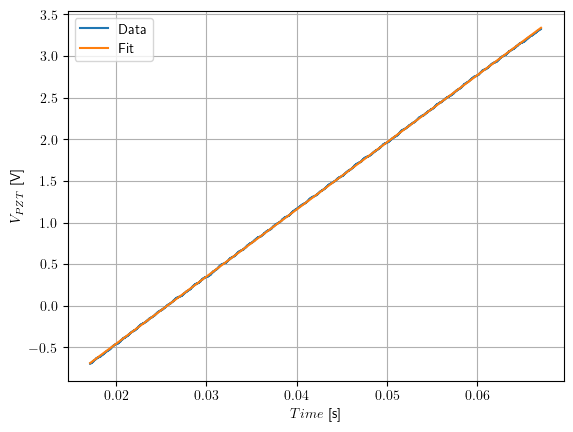

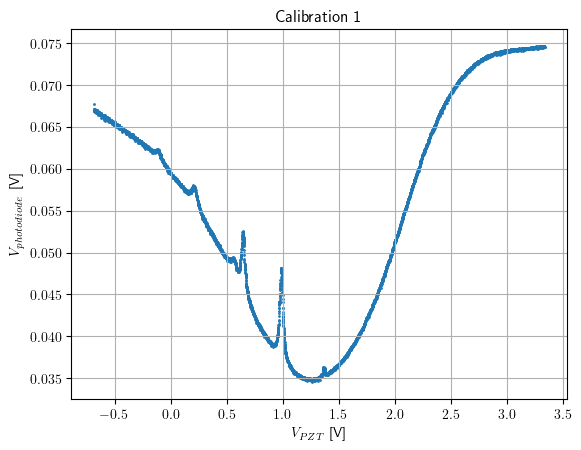

In [4]:
#Linear fit for the ramps of the PZT
fit, cov = curve_fit(Retta, time_1, piezo_1)
print('Linear fit y = mx + q with:\n\tm = ', fit[0], ' pm ', cov[0][0], '\n\tq = ', fit[1], ' pm ', cov[1][1])

R1 = Retta(time_1, fit[0], fit[1])

#Fit and data plot
plt.plot(time_1, piezo_1, label = 'Data')
plt.xlabel('$Time$ [s]')
plt.ylabel('$V_{PZT}$ [V]')
plt.grid()
plt.plot(np.linspace(min(time_1), max(time_1)), Retta(np.linspace(min(time_1), max(time_1)), fit[0], fit[1]), label = 'Fit')
plt.legend()
plt.show()

plt.scatter(R1, diod_1, s = 1)
plt.xlabel('$V_{PZT}$ [V]')
plt.ylabel('$V_{photodiode}$ [V]')
plt.title('Calibration 1')
plt.grid()
plt.show()

In [5]:
print(np.where(R1 == 0.9845880748214584))

(array([3188]),)


In [6]:
graph = go.Figure(data = go.Scatter(x = R1, y = diod_1, mode = 'markers'))
graph.show()

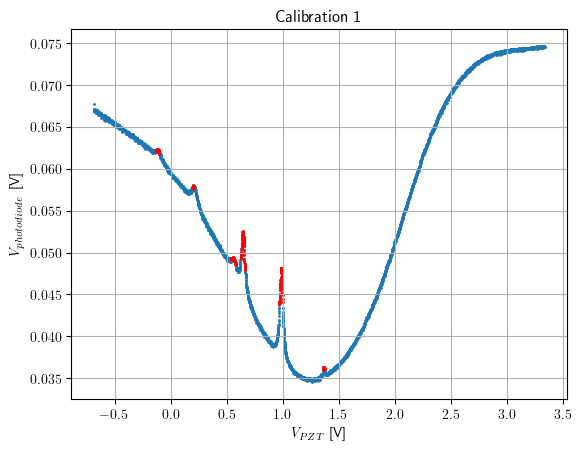

In [150]:
#Peaks positions at first glance
x_peaks_1_initial_value = [-0.1157522351469189, 0.201028323322054, 0.5602909787575561, 0.6452553338081279, 0.9845880748214584, 1.3685009045283318]

x_peaks_1_initial_position = []
for i in x_peaks_1_initial_value:
    x_peaks_1_initial_position.append(R1.tolist().index(i))

x_peaks_1_fit_interval = [30, 15, 40, 41, 30, 13] #points bafore and after the peak point

x_lists = []
x = []
y_lists = []
y = []
for i in range(0, len(x_peaks_1_initial_position)):
    x_lists.append(R1[x_peaks_1_initial_position[i]-x_peaks_1_fit_interval[i] : x_peaks_1_initial_position[i]+x_peaks_1_fit_interval[i]].tolist())

    x += x_lists[-1]

    y_lists.append(diod_1[x_peaks_1_initial_position[i]-x_peaks_1_fit_interval[i] : x_peaks_1_initial_position[i]+x_peaks_1_fit_interval[i]].tolist())

    y += y_lists[-1]
    

plt.scatter(R1, diod_1, s = 1)
plt.xlabel('$V_{PZT}$ [V]')
plt.ylabel('$V_{photodiode}$ [V]')
plt.title('Calibration 1')
plt.grid()
plt.scatter(x, y, s = 1, c='r')
plt.show()

### Picco a scelta

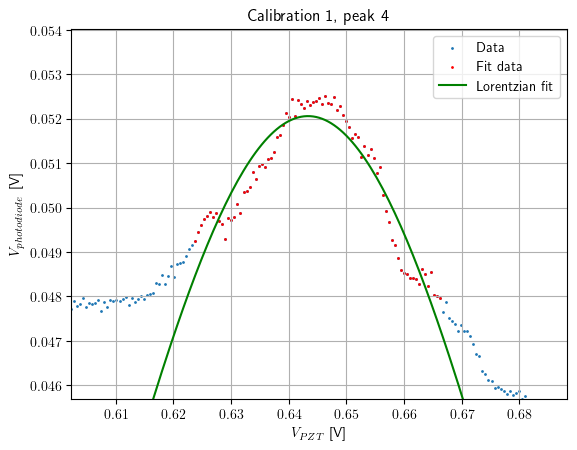

Calibration 1, peak  4  at  0.6433324001203441  pm  6.475194867584255e-08


In [151]:
i = 3

plt.scatter(R1, diod_1, s = 1, label = 'Data')
plt.xlabel('$V_{PZT}$ [V]')
plt.ylabel('$V_{photodiode}$ [V]')
plt.title('Calibration 1, peak ' + str(i+1))
plt.grid()
#plt.xlim([0.94, 1.02])
plt.xlim([R1[x_peaks_1_initial_position[i]-2*x_peaks_1_fit_interval[i]], R1[x_peaks_1_initial_position[i]+2*x_peaks_1_fit_interval[i]]])
#plt.ylim([0.039, 0.049])
spacing = 3.0
plt.ylim([min(y_lists[i]) - (max(y_lists[i]) - min(y_lists[i]))/(spacing - 1.0), max(y_lists[i]) + (max(y_lists[i]) - min(y_lists[i]))/spacing])
plt.scatter(x, y, s = 1, c='r', label = 'Fit data')

Lfit, Ldev = curve_fit(Lorentzian, x_lists[i], y_lists[i], maxfev=10000)
#Gfit, Gdev = curve_fit(Gaussian, x_lists[i], y_lists[i], maxfev=10000)

#plt.plot(np.linspace(x_lists[i][0], x_lists[i][-1]), Lorentzian(np.linspace(x_lists[i][0], x_lists[i][-1]), Lfit[0], Lfit[1], Lfit[2]), label = 'Lorentzian fit', c='g')

plt.plot(R1[x_peaks_1_initial_position[i]-2*x_peaks_1_fit_interval[i] : x_peaks_1_initial_position[i]+2*x_peaks_1_fit_interval[i]], Lorentzian(R1[x_peaks_1_initial_position[i]-2*x_peaks_1_fit_interval[i] : x_peaks_1_initial_position[i]+2*x_peaks_1_fit_interval[i]], Lfit[0], Lfit[1], Lfit[2]), label = 'Lorentzian fit', c='g')

#plt.plot(R1[x_peaks_1_initial_position[i]-2*x_peaks_1_fit_interval[i] : x_peaks_1_initial_position[i]+2*x_peaks_1_fit_interval[i]], Gaussian(R1[x_peaks_1_initial_position[i]-2*x_peaks_1_fit_interval[i] : x_peaks_1_initial_position[i]+2*x_peaks_1_fit_interval[i]], Gfit[0], Gfit[1]), label = 'Gaussian fit', c='m')

plt.legend()
plt.show()

print('Calibration 1, peak ', i+1, ' at ', Lfit[1], ' pm ', Ldev[1][1])

### All the peaks

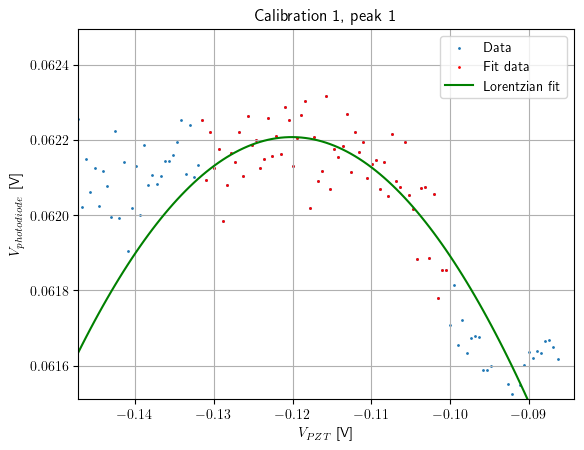

Calibration 1, peak  1  at  -0.12010316011688864  pm  1.0197719189168445e-06


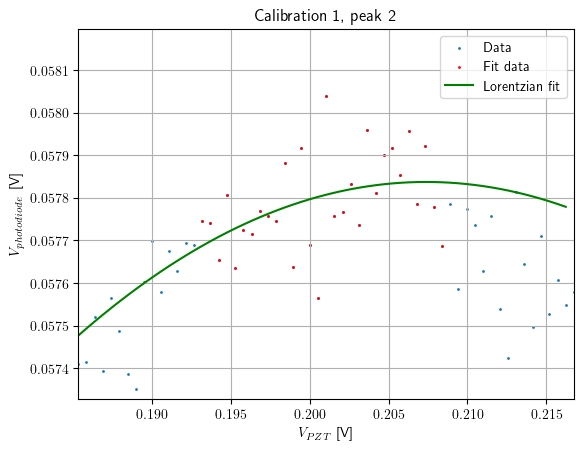

Calibration 1, peak  2  at  0.2073799518252466  pm  9.121879529369836e-05


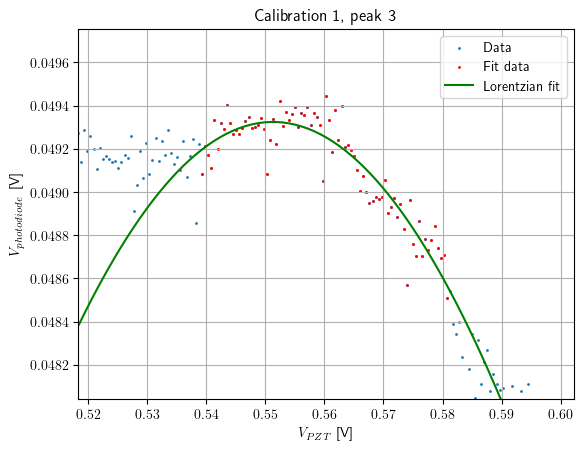

Calibration 1, peak  3  at  0.5513113217824821  pm  8.331753805301041e-07


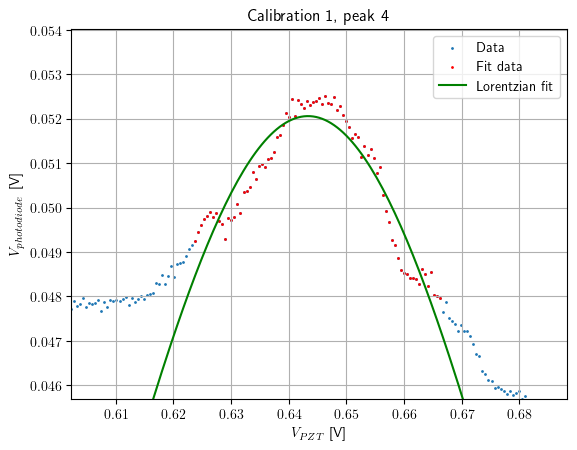

Calibration 1, peak  4  at  0.6433324001203441  pm  6.475194867584255e-08


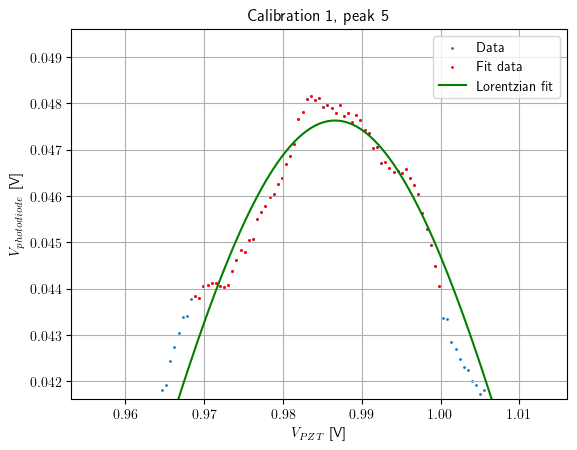

Calibration 1, peak  5  at  0.9866029619838791  pm  5.2132806161890613e-08


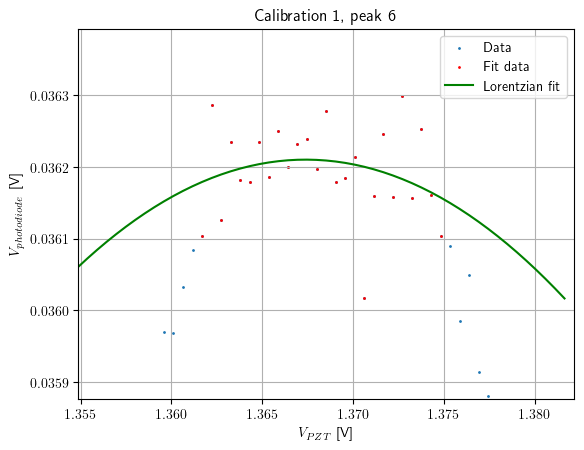

Calibration 1, peak  6  at  1.3673781971674432  pm  3.4697774518144517e-06


In [166]:
x_peaks_1_final_value = []
x_peaks_1_final_value_sigma = []

for i in range(0, 6):
    plt.scatter(R1, diod_1, s = 1, label = 'Data')
    plt.xlabel('$V_{PZT}$ [V]')
    plt.ylabel('$V_{photodiode}$ [V]')
    plt.title('Calibration 1, peak ' + str(i+1))
    plt.grid()
    #plt.xlim([0.94, 1.02])
    plt.xlim([R1[x_peaks_1_initial_position[i]-2*x_peaks_1_fit_interval[i]], R1 [x_peaks_1_initial_position[i]+2*x_peaks_1_fit_interval[i]]])
    #plt.ylim([0.039, 0.049])
    spacing = 3.0
    plt.ylim([min(y_lists[i]) - (max(y_lists[i]) - min(y_lists[i]))/(spacing - 1.0), max(y_lists[i]) + (max(y_lists[i]) - min(y_lists[i]))/spacing])
    plt.scatter(x, y, s = 1, c='r', label = 'Fit data')

    Lfit, Ldev = curve_fit(Lorentzian, x_lists[i], y_lists[i], maxfev=50000)
    x_peaks_1_final_value.append(Lfit[1])
    x_peaks_1_final_value_sigma.append(Ldev[1][1])
    #Gfit, Gdev = curve_fit(Gaussian, x_lists[i], y_lists[i], maxfev=10000)

    #plt.plot(np.linspace(x_lists[i][0], x_lists[i][-1]), Lorentzian(np.linspace    (x_lists[i][0], x_lists[i][-1]), Lfit[0], Lfit[1], Lfit[2]), label =    'Lorentzian fit', c='g')

    plt.plot(R1[x_peaks_1_initial_position[i]-2*x_peaks_1_fit_interval[i] :     x_peaks_1_initial_position[i]+2*x_peaks_1_fit_interval[i]], Lorentzian(R1   [x_peaks_1_initial_position[i]-2*x_peaks_1_fit_interval[i] :   x_peaks_1_initial_position[i]+2*x_peaks_1_fit_interval[i]], Lfit[0], Lfit[1], Lfit[2]), label = 'Lorentzian fit', c='g')

    #plt.plot(R1[x_peaks_1_initial_position[i]-2*x_peaks_1_fit_interval[i] :    x_peaks_1_initial_position[i]+2*x_peaks_1_fit_interval[i]], Gaussian(R1    [x_peaks_1_initial_position[i]-2*x_peaks_1_fit_interval[i] :    x_peaks_1_initial_position[i]+2*x_peaks_1_fit_interval[i]], Gfit[0], Gfit[1]),     label = 'Gaussian fit', c='m')

    plt.legend()
    plt.show()
    plt.close()

    print('Calibration 1, peak ', i+1, ' at ', Lfit[1], ' pm ', Ldev[1][1])

Now that we know the relative distance of the peaks we can compare these data with the theoretical results to calibrate our PZT. We assume that at room temperature the thermal gs of Cs is the state 6s with F = 4. Due to selection rules ($\Delta F = 0,\pm 1$), the allowed transitions from this state are those with:

$F^\prime = 3$ at frequency $f_3$

$F^\prime = 4$ at frequency $f_4$

$F^\prime = 5$ at frequency $f_5$

But, due to the pumping action we are operating on the system, we are able also to capture transition within the 6p J=3/2 between:

$F = 3$ and $F = 4$ at frequency $f_{34} = \frac{f_3 + f_4}{2}$

$F = 3$ and $F = 5$ at frequency $f_{35} = \frac{f_3 + f_5}{2}$

$F = 4$ and $F = 5$ at frequency $f_{45} = \frac{f_4 + f_5}{2}$

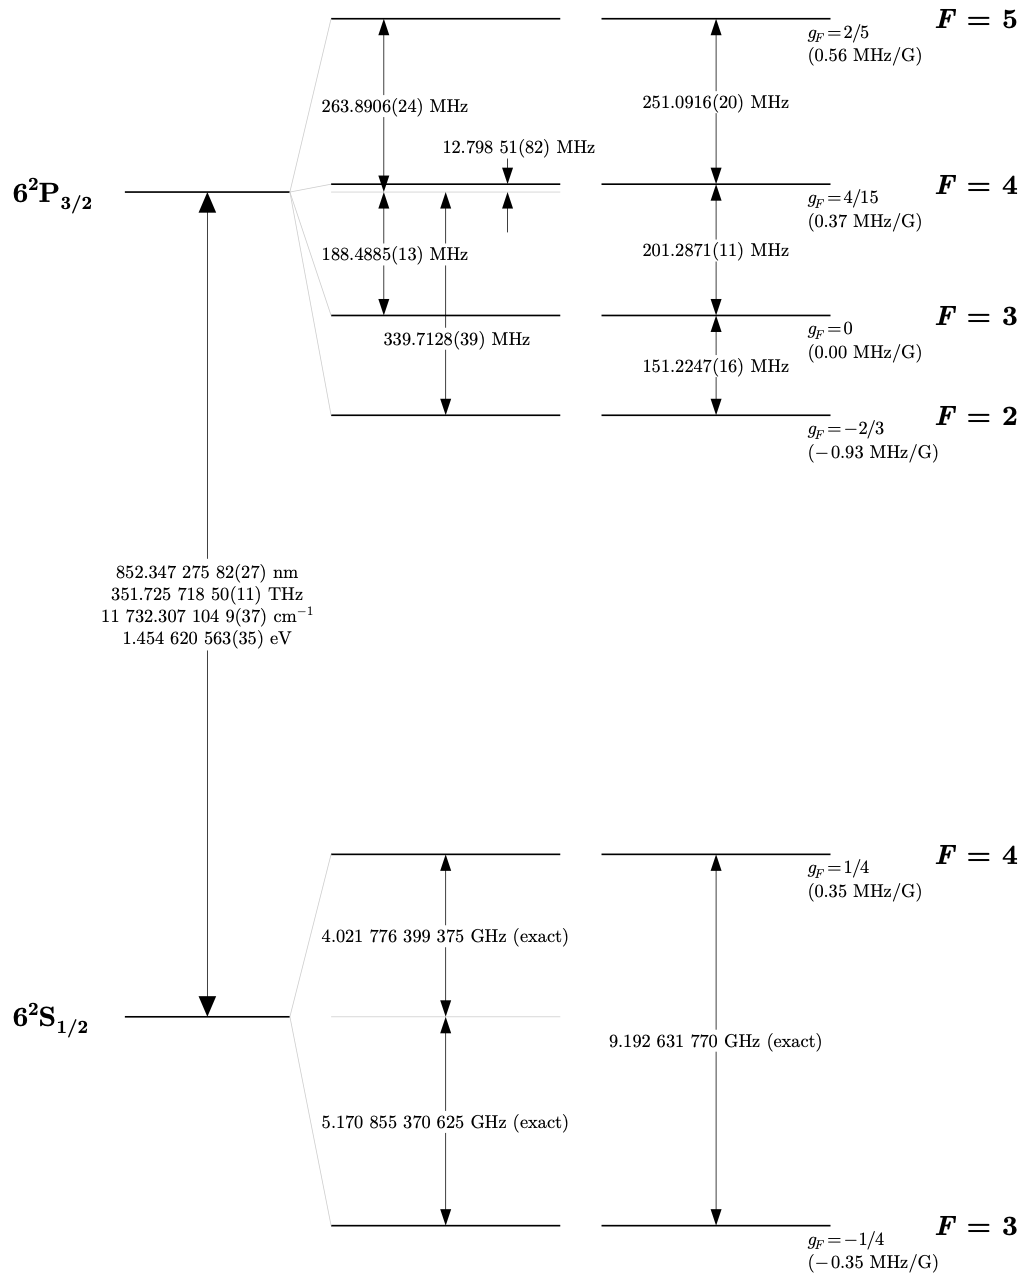

In [162]:
Image("Th_data.png", width=600)

[351.72150824 351.72160888 351.72170952 351.72173442 351.72183507
 351.72196061]
[-0.12010316011688864, 0.2073799518252466, 0.5513113217824821, 0.6433324001203441, 0.9866029619838791, 1.3673781971674432]
[3.01173489e-04 3.51721544e+02]
[[ 1.35358751e-11 -8.20009415e-12]
 [-8.20009415e-12  8.14941559e-12]]


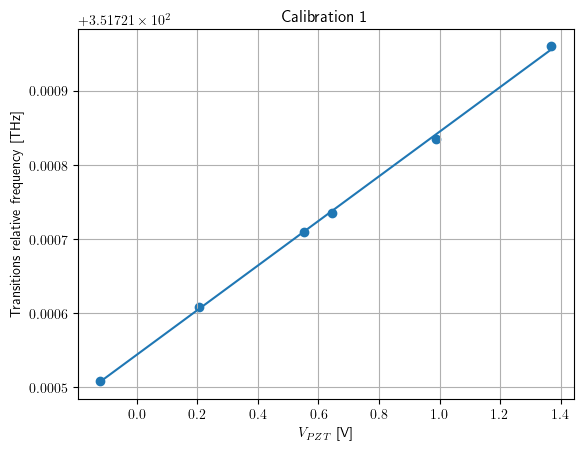

[351.72150745 351.72160607 351.72170966 351.72173737 351.72184076
 351.72195544]
[351.72150824 351.72160888 351.72170952 351.72173442 351.72183507
 351.72196061]
[ 7.89388309e-07  2.80366191e-06 -1.35843777e-07 -2.94761298e-06
 -5.68810077e-06  5.17853817e-06]


In [221]:
f3 = 351.72571850 - 4.021776399375e-3 - 188.4885e-6 #THz
f4 = 351.72571850 - 4.021776399375e-3 + 12.79851e-6 #THz
f5 = 351.72571850 - 4.021776399375e-3 + 263.8906e-6 #THz
f34 = (f3 + f4)/2.0
f35 = (f3 + f5)/2.0
f45 = (f4 + f5)/2.0

f = [f3, f4, f5, f34, f35, f45]
f.sort()
f = np.array(f)
print(f)

print(x_peaks_1_final_value)

C1, C1err = curve_fit(Retta, x_peaks_1_final_value, f, maxfev=100000)

print(C1)
print(C1err)

plt.scatter(x_peaks_1_final_value, f)
x = np.linspace(min(x_peaks_1_final_value), max(x_peaks_1_final_value))
plt.plot(x, Retta(x, C1[0], C1[1]))
plt.grid()
plt.xlabel('$V_{PZT}$ [V]')
plt.ylabel('Transitions relative frequency [THz]')
plt.title('Calibration 1')
plt.show()

res = C1[0]*np.array(x_peaks_1_final_value) + C1[1]
print(res)
print(f)
print(f-res)

In [222]:
Calibrated_m = 3.01173489e-04 #THz/V
Calibrated_q = 3.51721544e+02 #THz

# Power broadening

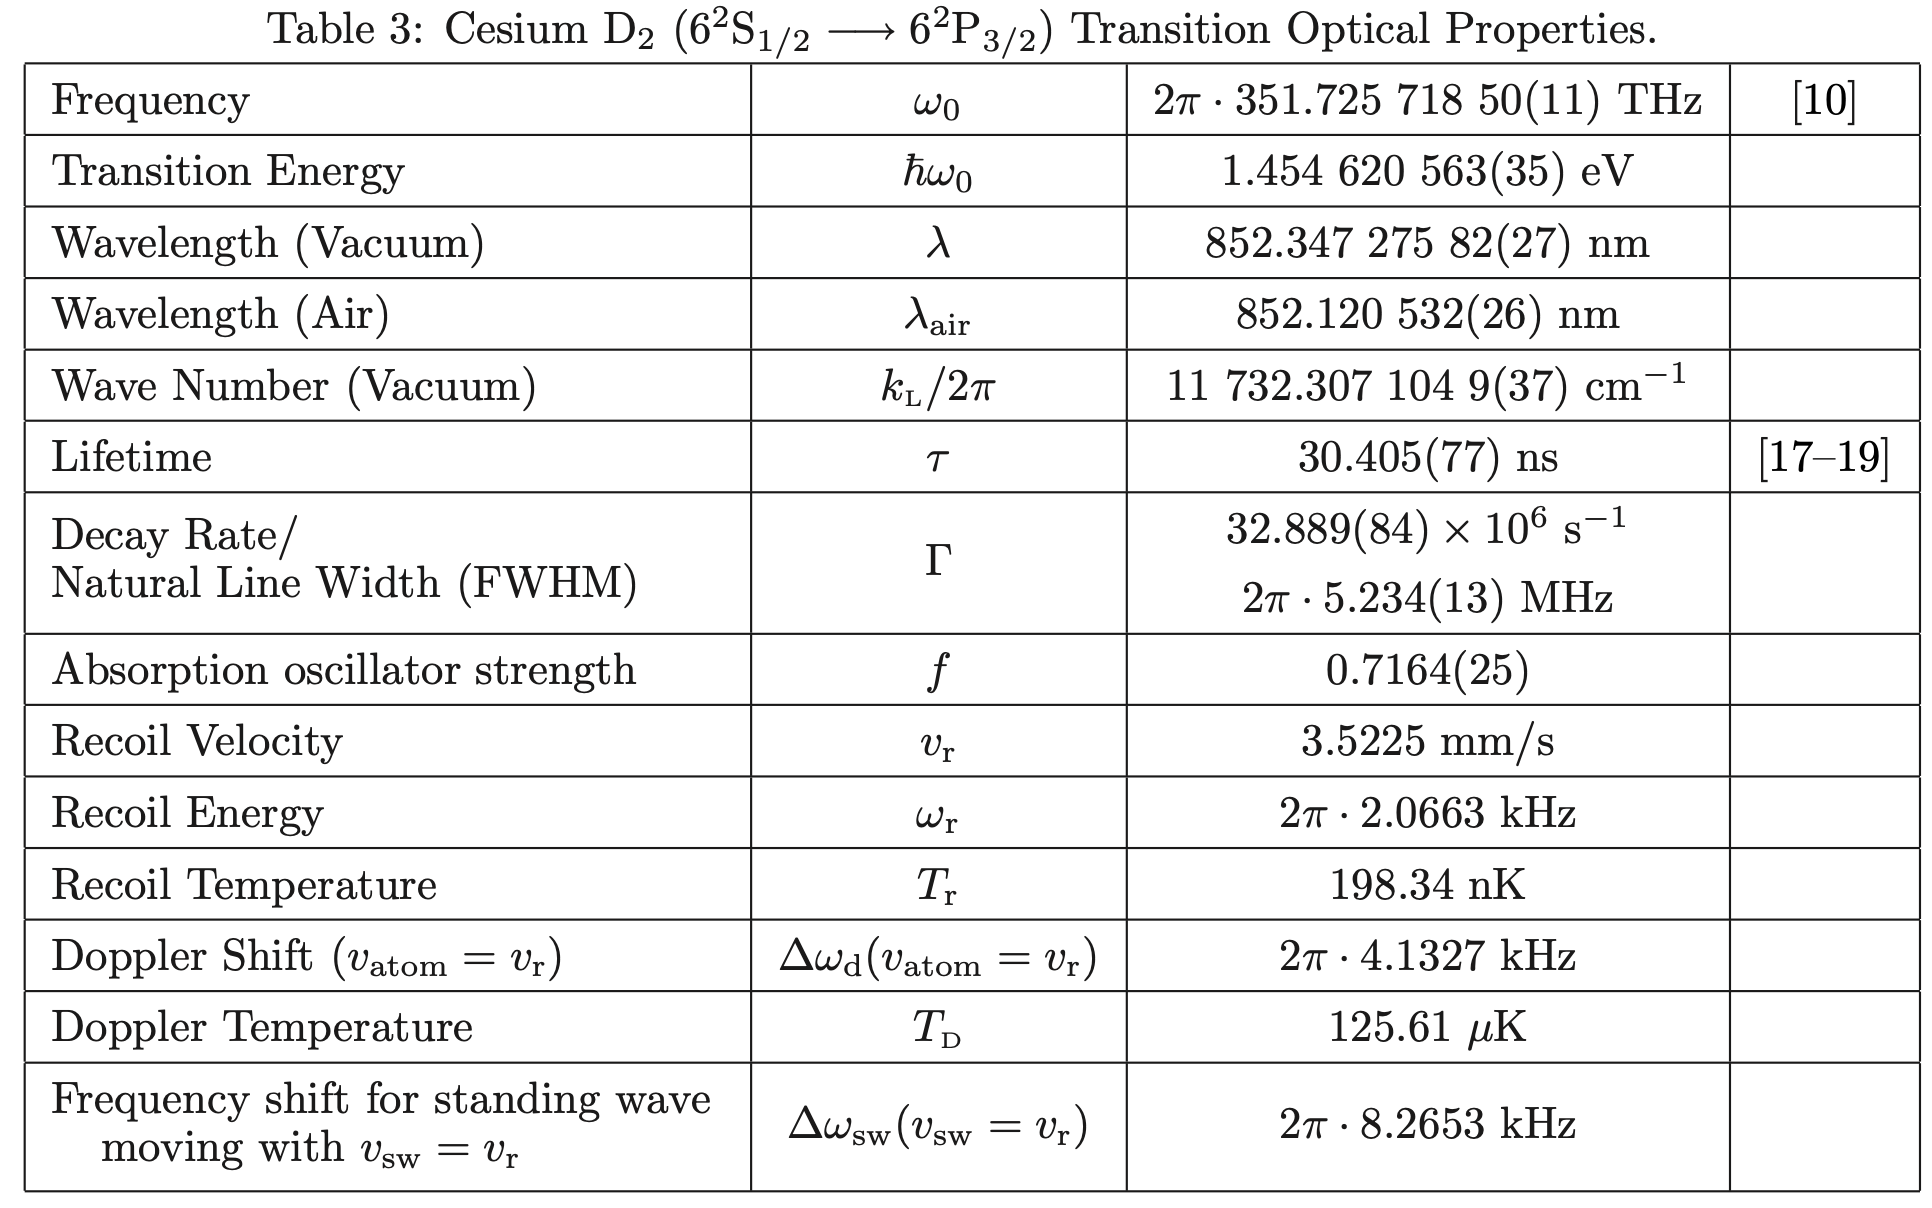

In [227]:
Image("Table1_D2.png", width=600)

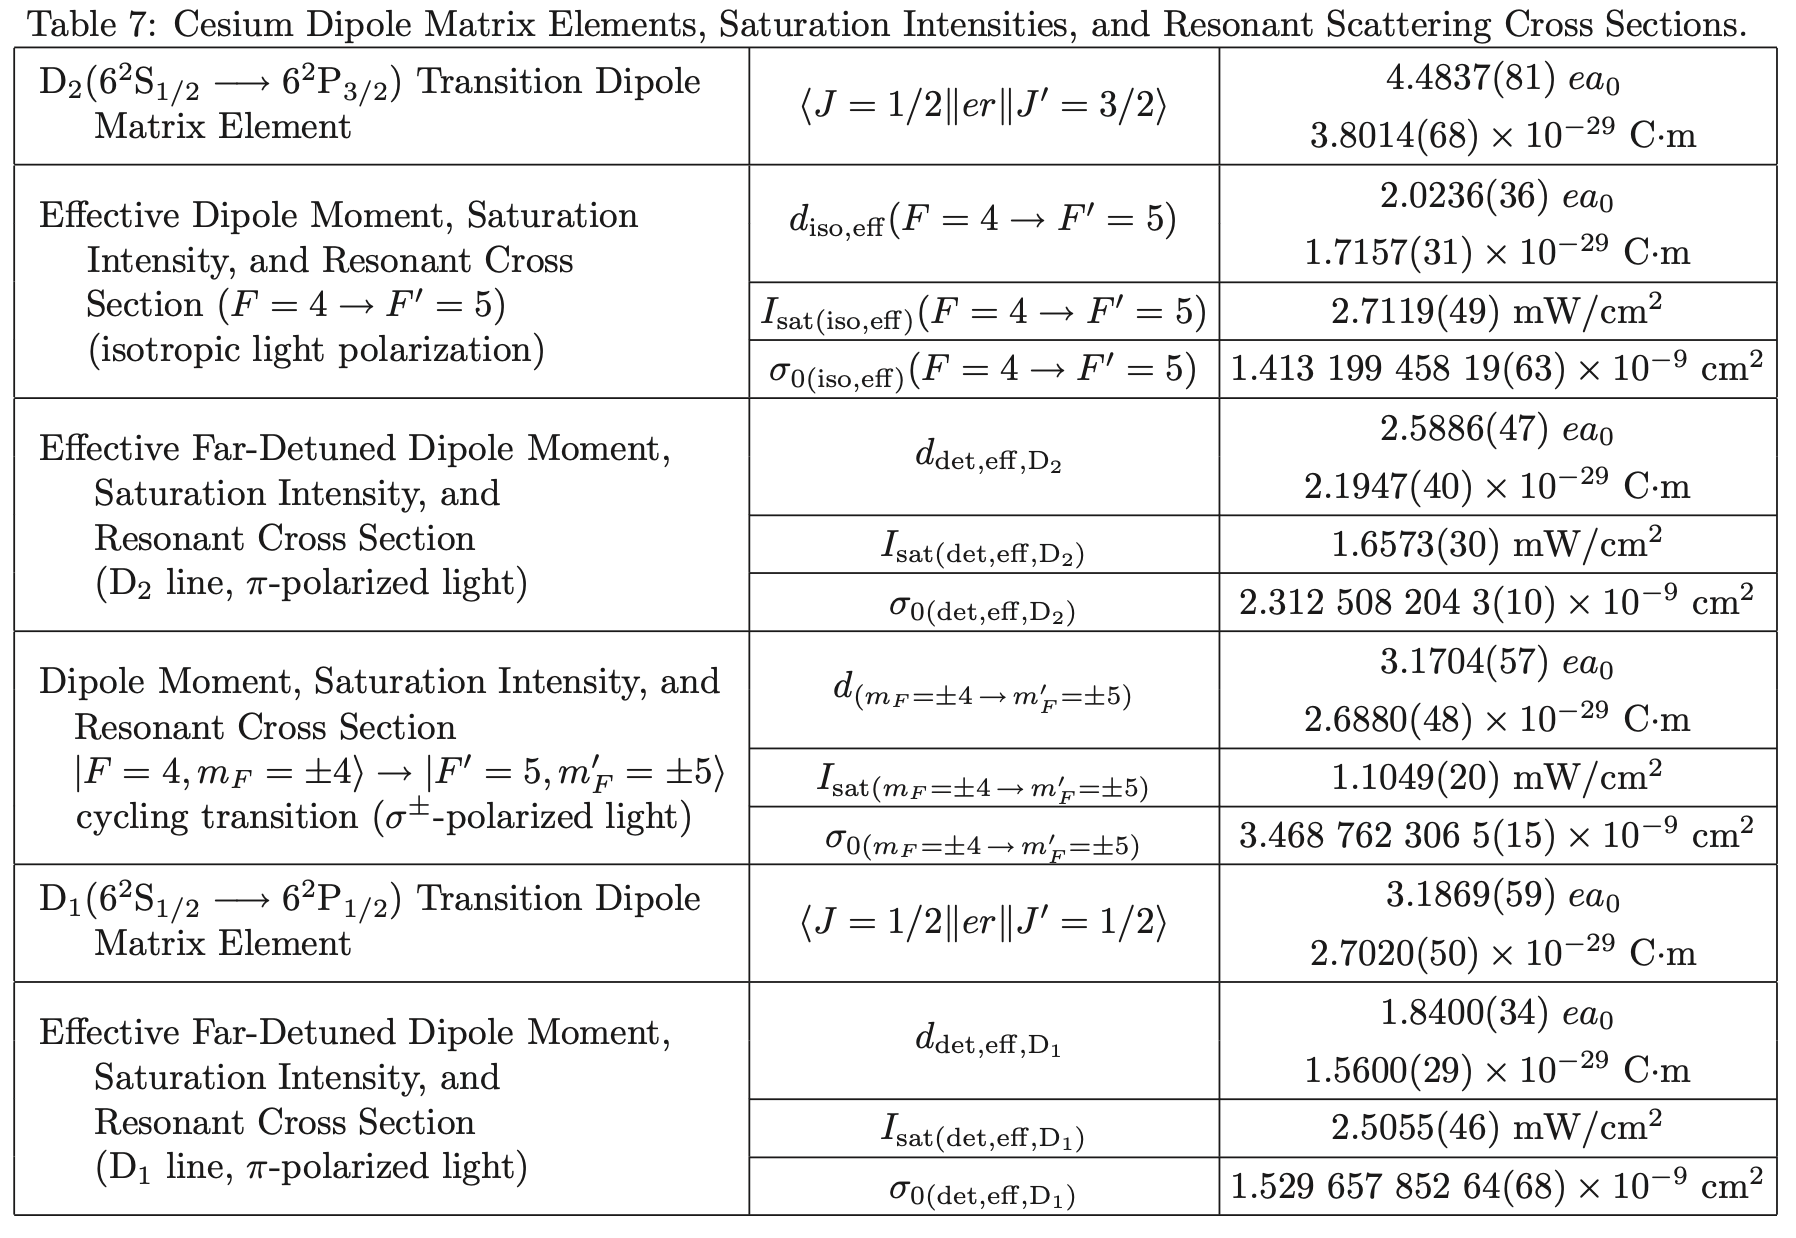

In [226]:
Image("Table2_D2.png", width=600)

In [ ]:
Calibrated_m = 3.01173489e-04 #THz/V
Calibrated_q = 3.51721544e+02 #THz
Isat = 2.7119 #mW/cm^2

d = 0.25 #cm, diametro del fascio
S = np.pi*(d/2.0)**2 #cm^2 sezione del fascio

Gamma_th = 2.0*np.pi*5.234 #Mhz, decay rate, natural linewidth FWHM

We know that the FWHM of the Lamb-Deep feature is $\Gamma \sqrt{1+I/I_{sat}}$, so we can try to obtain an estimate of the Natural Line Width. The scopes taken for this purpose are scope X-Y.

To do so we consider the scope in which the power broadening is smaller, though the one with the minimum intensity necessary to actually see the Lamb-Deep feature (scope_13 or scope_ 14)

In [230]:
#Import data scope_13
data_LD_1 = pd.read_csv('Data/Data_15_11/scope_13.csv', skiprows=2, names=['time', 'volt_piezo', 'volt_photodiod'], dtype={'timestamp': float, 'volt_piezo': float, 'volt_photodiod': float})

data_LD_1 = data_LD_1.dropna()

time_LD_1 = data_LD_1['time'].to_numpy()
piezo_LD_1 = data_LD_1['volt_piezo'].to_numpy()
diod_LD_1 = data_LD_1['volt_photodiod'].to_numpy()

In [232]:
graph = go.Figure(data = go.Scatter(x = R1, y = diod_LD_1, mode = 'markers'))
graph.show()

In [ ]:
LD_V_initial_pos = 3170
LD_V_interval_fit = 20

plt.scatter(R1, diod_LD_1, s = 1, label = 'Data')
plt.xlabel('$V_{PZT}$ [V]')
plt.ylabel('$V_{photodiode}$ [V]')
plt.title('Lamb-Deep feature' + str(i+1))
plt.grid()
#plt.xlim([0.94, 1.02])
x_int = [R1[LD_V_initial_pos-2*LD_V_interval_fit], R1[LD_V_initial_pos-2*LD_V_interval_fit]]
plt.xlim(x_int)
#plt.ylim([0.039, 0.049])
spacing = 3.0

y_int = [min(diod_LD_1[LD_V_initial_pos-LD_V_interval_fit:LD_V_initial_pos+LD_V_interval_fit]) - (max(diod_LD_1[LD_V_initial_pos-LD_V_interval_fit:LD_V_initial_pos+LD_V_interval_fit]) - min(diod_LD_1[LD_V_initial_pos-LD_V_interval_fit:LD_V_initial_pos+LD_V_interval_fit]))/(spacing -1.0), max(diod_LD_1[LD_V_initial_pos-LD_V_interval_fit:LD_V_initial_pos+LD_V_interval_fit]) + (max(diod_LD_1[LD_V_initial_pos-LD_V_interval_fit:LD_V_initial_pos+LD_V_interval_fit]) - min(diod_LD_1[LD_V_initial_pos-LD_V_interval_fit:LD_V_initial_pos+LD_V_interval_fit]))/spacing]
plt.ylim(y_int)
plt.scatter(x, y, s = 1, c='r', label = 'Fit data')
Lfit, Ldev = curve_fit(Lorentzian, x_lists[i], y_lists[i], maxfev=50000)
x_peaks_1_final_value.append(Lfit[1])
x_peaks_1_final_value_sigma.append(Ldev[1][1])
#Gfit, Gdev = curve_fit(Gaussian, x_lists[i], y_lists[i], maxfev=10000)
#plt.plot(np.linspace(x_lists[i][0], x_lists[i][-1]), Lorentzian(nplinspace    (x_lists[i][0], x_lists[i][-1]), Lfit[0], Lfit[1], Lfit[2]),label =    'Lorentzian fit', c='g')
plt.plot(R1[x_peaks_1_initial_position[i]-2*x_peaks_1_fit_interval[i] :    x_peaks_1_initial_position[i]+2*x_peaks_1_fit_interval[i]], Lorentzian(R1  [x_peaks_1_initial_position[i]-2*x_peaks_1_fit_interval[i] :  x_peaks_1_initial_position[i]+2*x_peaks_1_fit_interval[i]], Lfit[0], Lfi[1], Lfit[2]), label = 'Lorentzian fit', c='g')
#plt.plot(R1[x_peaks_1_initial_position[i]-2*x_peaks_1_fit_interval[i] :   x_peaks_1_initial_position[i]+2*x_peaks_1_fit_interval[i]], Gaussian(R1   [x_peaks_1_initial_position[i]-2*x_peaks_1_fit_interval[i] :   x_peaks_1_initial_position[i]+2*x_peaks_1_fit_interval[i]], Gfit[0], Gfi[1]),     label = 'Gaussian fit', c='m')
plt.legend()
plt.show()
plt.close()
print('Calibration 1, peak ', i+1, ' at ', Lfit[1], ' pm ', Ldev[1][1])

------------------------------------
# Tests

[351.72150824 351.72160888 351.72170952 351.72173442 351.72183507
 351.72196061]
[-0.12010316011688864, 0.2073799518252466, 0.5513113217824821, 0.6433324001203441, 0.9866029619838791, 1.3673781971674432]
[3.01173489e-04 3.51721544e+02]
[[ 1.35358751e-11 -8.20009415e-12]
 [-8.20009415e-12  8.14941559e-12]]


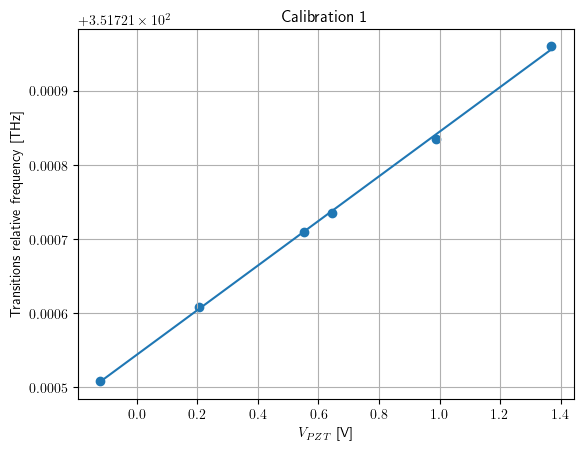

[351.72150745 351.72160607 351.72170966 351.72173737 351.72184076
 351.72195544]
[351.72150824 351.72160888 351.72170952 351.72173442 351.72183507
 351.72196061]
[ 7.89388309e-07  2.80366191e-06 -1.35843777e-07 -2.94761298e-06
 -5.68810077e-06  5.17853817e-06]


In [ ]:
f3 = 351.72571850*10**12 - 4.021776399375*10**9 - 188.4885*10**6 #Hz
f4 = 351.72571850*10**12 - 4.021776399375*10**9 + 12.79851*10**6 #Hz
f5 = 351.72571850*10**12 - 4.021776399375*10**9 + 263.8906*10**6 #Hz
f34 = (f3 + f4)/2.0
f35 = (f3 + f5)/2.0
f45 = (f4 + f5)/2.0

f = [f3, f4, f5, f34, f35, f45]
f.sort()
f = np.array(f)
print(f)
print(x_peaks_1_final_value)
m = 3.0141e-04 #THz/V
q = 1.5435e-03 + 3.5172e2 #THz

plt.errorbar(x_peaks_1_final_value, f/(10**12), xerr = x_peaks_1_final_value_sigma, fmt="o")
x = np.linspace(min(x_peaks_1_final_value), max(x_peaks_1_final_value))
plt.plot(x, Retta(x, m, q))
plt.grid()
plt.xlabel('$V_{PZT}$ [V]')
plt.ylabel('Transitions relative frequency [THz]')
plt.title('Calibration 1')
plt.show()
C1, C1err = curve_fit(Retta, x_peaks_1_final_value, f, maxfev=100000)

print(C1)
print(C1err)
res = m*np.array(x_peaks_1_final_value) + q
print(res)
print(f)
print(f-res)

## Finding peaks NOPE

23


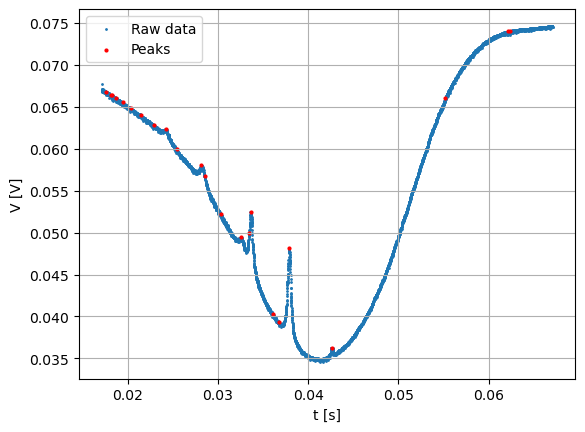

In [64]:
data = pd.read_csv('Data/Data_15_11/scope_5.csv', skiprows=2, names=['time', 'volt_piezo', 'volt_photodiod'], dtype={'timestamp': float, 'volt_piezo': float, 'volt_photodiod': float})

#remove all NaN data
data_cleaned = data.dropna()

plt.scatter(data['time'].to_numpy(), data['volt_photodiod'].to_numpy(), s = 1, label = 'Raw data')
plt.xlabel('t [s]')
plt.ylabel('V [V]')
plt.grid()


peaks, _ = find_peaks(data['volt_photodiod'].to_numpy(), prominence = 0.0004, width = 4)

print(len(peaks))

plt.scatter(data['time'].to_numpy()[peaks], data['volt_photodiod'].to_numpy()[peaks], s = 4, c = 'r', label = 'Peaks')
plt.legend()
plt.show()
plt.close()